<a href="https://colab.research.google.com/github/walkidni/grayscale-image-colorization/blob/main/colorization_model_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model_testing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/colorization'

Mounted at /content/drive
/content/drive/MyDrive/colorization


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision import datasets, transforms

from skimage import color
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt





In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = nn.LeakyReLU(0.2)(self.conv1(x))
        x = nn.LeakyReLU(0.2)(self.conv2(x))
        x = self.bn(x)
        return x

class DecoderConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2) 
        self.conv = DoubleConv(out_channels + out_channels, out_channels)

    def forward(self, x, x1):
        y1 = self.up_conv(x)
        y2 = torch.cat((y1, x1), dim=-3)
        y = self.conv(y2)
        return y

class UNet(nn.Module):
    def __init__(self, size):
        super().__init__()
        # non trainable layers
        self.pool = nn.MaxPool2d(kernel_size=2)
        # trainable layers
        ## encoder 
        self.en_conv1 = DoubleConv(1,size)
        self.en_conv2 = DoubleConv(size,size*2)
        self.en_conv3 = DoubleConv(size*2,size*4)
        self.en_conv4 = DoubleConv(size*4,size*8)
        ## bottleneck
        self.conv = DoubleConv(size*8,size*16)
        self.drop = nn.Dropout(0)
        ## decoder
        self.de_conv4 = DecoderConv(size*16,size*8)
        self.de_conv3 = DecoderConv(size*8,size*4)
        self.de_conv2 = DecoderConv(size*4,size*2)
        self.de_conv1 = DecoderConv(size*2,size)
        ## reconstruct layer
        self.reconstruct = nn.Conv2d(size, 2, kernel_size=3, padding=1)

    def forward(self, x):
      # encoder inference 
        e1 = self.en_conv1(x)
        p1 = self.pool(e1)
        e2 = self.en_conv2(p1)
        p2 = self.pool(e2)
        e3 = self.en_conv3(p2) 
        p3 = self.pool(e3)
        e4 = self.en_conv4(p3)
        p4 = self.pool(e4)
      # bottleneck inference
        b = self.drop(self.conv(p4))
      # decoder inference 
        d4 = self.de_conv4(b,e4)
        d3 = self.de_conv3(d4,e3)
        d2 = self.de_conv2(d3,e2)
        d1 = self.de_conv1(d2,e1)
      # reconstruct image
        colored_image = self.reconstruct(d1)        
        return colored_image


In [ ]:

def stack_lab(l, ab):
  return torch.cat((l, ab))

def lab2rgb(lab, to_numpy):
  if lab.requires_grad :
    lab = lab.detach()
  lab = lab.permute((1,2,0))
  rgb = color.lab2rgb(lab)
  if to_numpy:
    return rgb
  else:
    return torch.from_numpy().permute(2,0,1)

def to_rgb(l, ab, to_numpy=True):
  lab = stack_lab(l,ab)
  rgb = lab2rgb(lab, to_numpy = to_numpy)
  return rgb

In [ ]:
class ColorizationDataset(Dataset):
  def __init__(self,root='./data', train=True, resize=None):
      self.cifar100 = datasets.CIFAR100(root=root, train=train, download=True)
      self.resize = resize

  def __len__(self):
      return len(self.cifar100)

  def __getitem__(self, index):
      image, label = self.cifar100[index]
      if self.resize:
        image = image.resize((self.resize, self.resize))

      lab_image = color.rgb2lab(image)
      lab_image = lab_image.astype(np.float32)
      L, ab = lab_image[:,:,0], lab_image[:,:,1:]
      L = torch.from_numpy(L).unsqueeze(dim=0)
      ab = torch.from_numpy(ab).permute((2,0,1))

      return L, ab


train_data = ColorizationDataset(
    root='./data',
    train=True,
    resize = None
)

test_data = ColorizationDataset(
    root='./data',
    train=False,
    resize = None
)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
gen=0

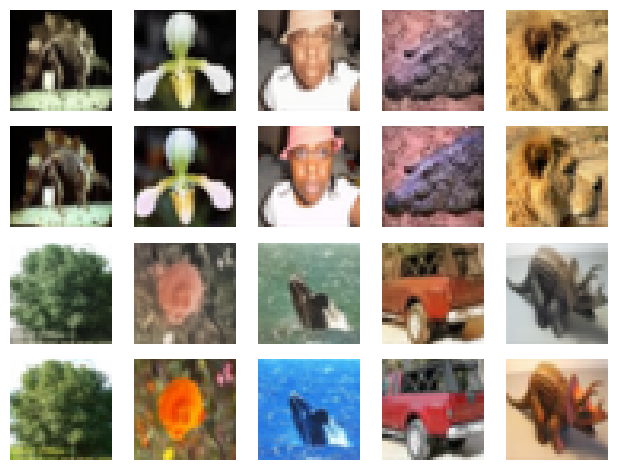

In [ ]:
import random 
model_name = '32unet_lab_bn_enc_dec'
model_path = f'models/{model_name}.pth'
model_size = 32


model=UNet(model_size)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

n_samples = 5

trainsampler = RandomSampler(train_data, replacement=False, num_samples=n_samples)
testsampler = RandomSampler(test_data, replacement=False, num_samples=n_samples)

trainloader = DataLoader(train_data, batch_size=1, sampler=trainsampler)
testloader = DataLoader(test_data, batch_size=1, sampler=testsampler)

fig, axes = plt.subplots(nrows=4, ncols=n_samples)  
for ax in axes.flat:
    ax.axis('off')
    ax.grid(False)

i=0
for l, ab in trainloader:
  pred = model(l)

  rgb_label = to_rgb(l.squeeze(dim=1), ab.squeeze())
  rgb_pred = to_rgb(l.squeeze(dim=1), pred.squeeze())

  axes[0][i].imshow(rgb_pred)

  axes[1][i].imshow(rgb_label)
  i+=1

i=0
for l, ab in testloader:
  pred = model(l)

  rgb_label = to_rgb(l.squeeze(dim=1), ab.squeeze())
  rgb_pred = to_rgb(l.squeeze(dim=1), pred.squeeze())

  axes[2][i].imshow(rgb_pred)

  axes[3][i].imshow(rgb_label)
  i+=1

fig.tight_layout()


In [ ]:
gen += 1
fig.savefig(f'figures/{model_name}{gen}.png')